In [1]:
from scipy.stats import (
    norm, binom, expon, t, chi2, pareto, ttest_1samp, ttest_ind, sem, bernoulli, mannwhitneyu, uniform, gamma
)
from tqdm import tqdm_notebook
import scipy.stats as stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.api import CompareMeans, DescrStatsW
import numpy as numpy
import math
from seaborn import distplot
from matplotlib import pyplot
import pandas as pd
import seaborn
from statsmodels.stats.api import CompareMeans, DescrStatsW
import warnings
warnings.filterwarnings('ignore')
numpy.random.seed(42)



In [2]:
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert):
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'

    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [3]:
inverse_plot_colorscheme()

# Критерий Манна-Уитни.

Давайте в этот раз придумаем новый критерий однородности, проверяющий смещение одной выборки относительно другой. Напомним нулевую гипотезу у критерия однородности:

$$
    H_0: F = G,\ vs. H_1: F \neq G
$$
где $F$, $G$ – функции распределения 2-ух выборок.

Для начала рассмотрим простой пример с 2 нормальными распределениями, где одно смещено относительно другого. Наш критерий должен будет детектирвоать, что это разные распределения.


In [4]:
distr_a = norm(loc=1, scale=1)
distr_b = norm(loc=3, scale=1)

Визуализируем:

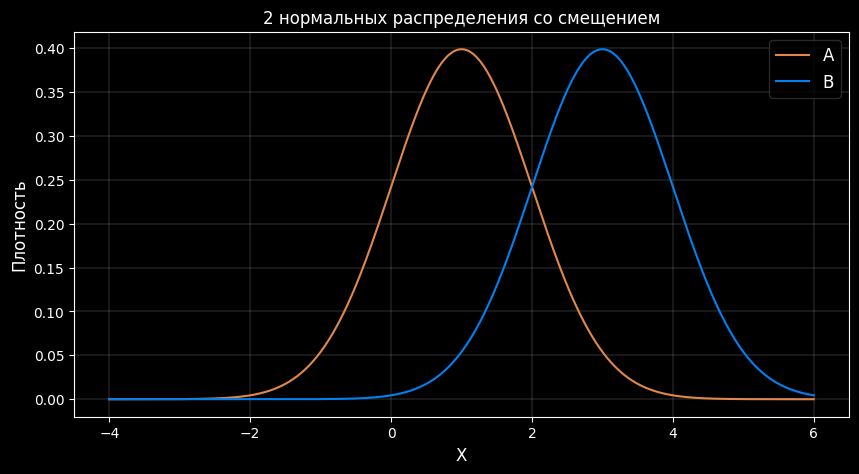

In [5]:
x = numpy.linspace(-4, 6, 1000)

pyplot.figure(figsize=(10, 5))
pyplot.title("2 нормальных распределения со смещением", fontsize=12)
pyplot.plot(x, distr_a.pdf(x), label='A')
pyplot.plot(x, distr_b.pdf(x), label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)
pyplot.show()


Что является "сердцем" любого критерия? Правильно, его статистика! Ее-то нам и надо придумать. Во время всех предыдущих лекций мы опирались на **значения** элементов выборок, в этот раз предлагается посмотреть не на сами значения, а на их **порядок** относительно друг друга.

Давайте сгенерируем выборки из наших искусственных нормальных распределений, и попытаемся их визуализировать.

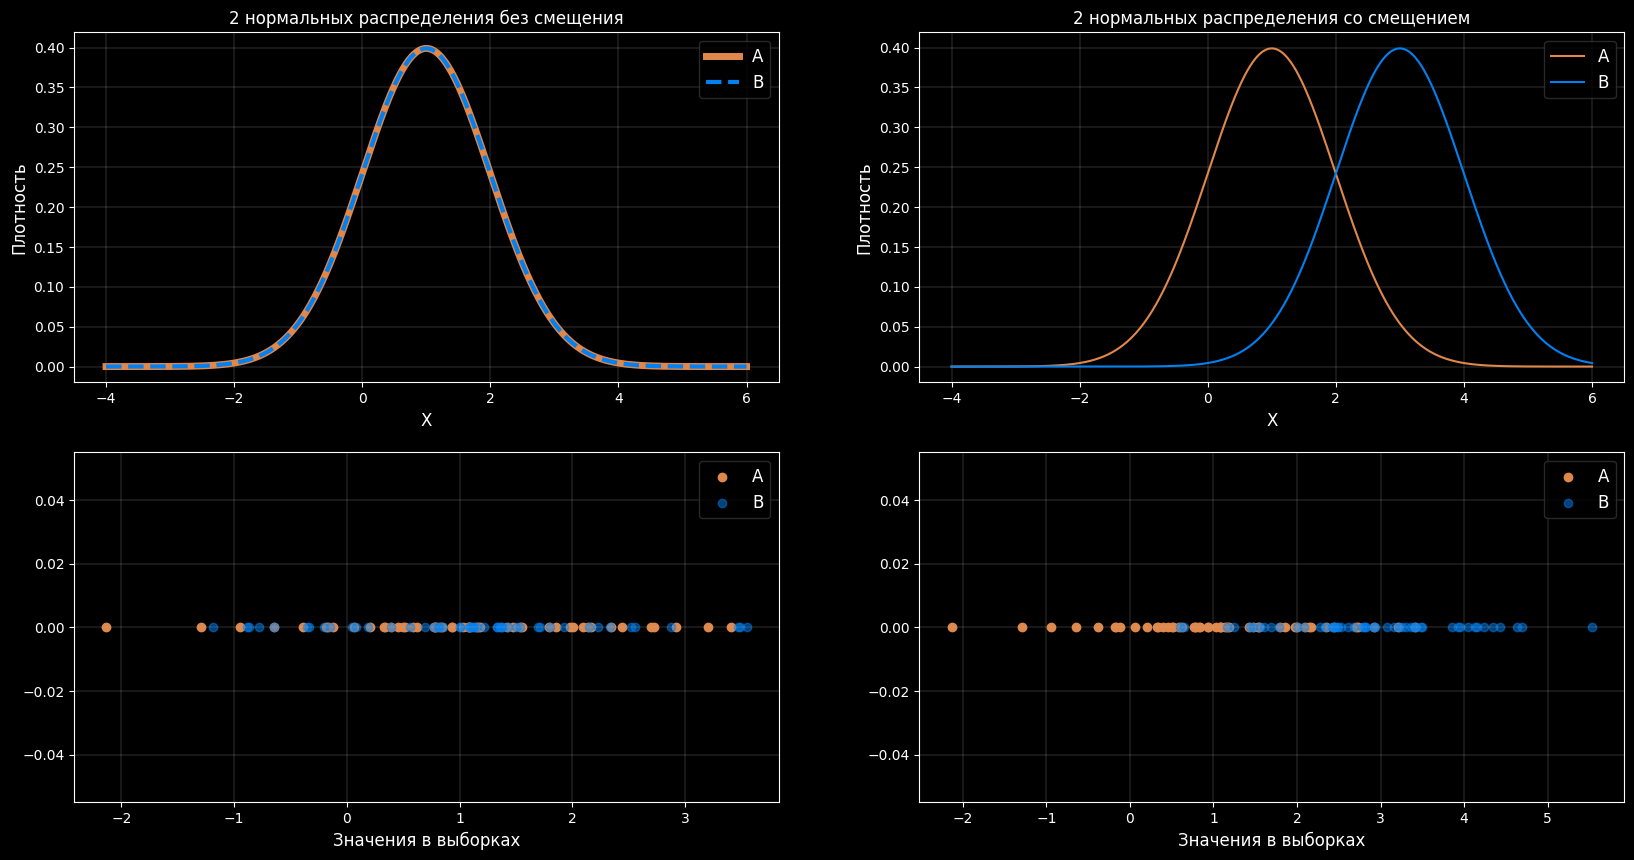

In [6]:
numpy.random.seed(8)
sample_a = distr_a.rvs(50)
sample_no_shift = distr_a.rvs(50)
sample_b = distr_b.rvs(50)

fig = pyplot.figure(figsize=(20, 10))

ax = fig.subplots(nrows=2, ncols=2)

pyplot.subplot(2, 2, 1)
pyplot.title("2 нормальных распределения без смещения", fontsize=12)
pyplot.plot(x, distr_a.pdf(x), lw=5, label='A')
pyplot.plot(x, distr_a.pdf(x), linestyle='--', lw=3, label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)


pyplot.subplot(2, 2, 2)
pyplot.title("2 нормальных распределения со смещением", fontsize=12)
pyplot.plot(x, distr_a.pdf(x), label='A')
pyplot.plot(x, distr_b.pdf(x), label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)



pyplot.subplot(2, 2, 3)
# pyplot.title("2 нормальных распределения без смещения", fontsize=12)
pyplot.scatter(sample_a, [0] * len(sample_a), label='A')
pyplot.scatter(sample_no_shift, [0] * len(sample_no_shift), alpha=0.5, label='B')
pyplot.xlabel(f'Значения в выборках', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)

pyplot.subplot(2, 2, 4)
# pyplot.title("2 нормальных распределения со смещением", fontsize=12)
pyplot.scatter(sample_a, [0] * len(sample_a), label='A')
pyplot.scatter(sample_b, [0] * len(sample_b), alpha=0.5, label='B')
pyplot.xlabel(f'Значения в выборках', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)
pyplot.show()


Мы видим, что в случае равенства распредений (отсутсвия смещения) значения перемешаны между собой. Это левая картинка. А когда присутствует смещение распределений (правая картинка) все значения в выборке $B$ больше, чем значения в выборке $A$. Отсюда мы видим простое правило: если все точки одного распределения "часто" левее второго распределения, то это 2 разных распределения. Где понятие "часто" предстоит определить.

**Идея:** давайте посчитаем число пар, где синий элемент больше рыжего, если таких пар очень много или мало, то одна выборка будет смещена относительно другой.

Наш критерий на языке математики это:
$$
\begin{align}
    U = \sum_{i}^N\sum_{j}^M I[A_i < B_j]
\end{align}
$$

где $A_1, ..., A_N$ &mdash; первая выборка, $B_1, ..., B_M$ &mdash; вторая выборка, $I$ &mdash; функция-индикатор, которая равна 1, если выполнено условие в скобках, и 0 иначе.

Напишем код для подсчета.

In [7]:
def calculate_U(A, B):
    """
        Функция для подсчета статистики U
    """
    U = 0
    for A_elem in A:
        for B_elem in B:
            U += A_elem < B_elem
    return U

In [9]:
calculate_U(sample_a, sample_b)

np.int64(2205)

Ага, теперь нам надо понять, 2205 это много или мало? Давайте посчитаем мат. ожидание U, если у нас нет никакого смещения. В этом случае для любой пары вероятность, что одно значение будет больше второго, равна 0.5.

$$
\begin{align}
    \mathbb{E} U = \sum_{i}^N\sum_{j}^M \mathbb{P}[A_i < B_j] \cdot I[A_i < B_j] = \sum_{i}^N\sum_{j}^M \mathbb{P}[A_i < B_j] = \sum_{i}^N\sum_{j}^M \dfrac{1}{2} = \dfrac{NM}{2}
\end{align}
$$

В нашем случае мат. ожидание равно:


In [10]:
len(sample_a) * len(sample_b) / 2

1250.0

Мы видим, что отличие есть. Понятно, что чем оно больше, тем вероятней есть смещение одной выборки относительно другой. Теперь осталось это выразить статистически: как распределена $U$ относительно мат. ожидания, когда выборки из одного распределения? Тогда мы сможем понять, насколько текущее отличие больше.  

Для этого нам надо понять, как распределена статистика $U$ при справедливости $H_0$  
Cгенерируем распределение $U$ с помощью Монте-Карло:

  0%|          | 0/10000 [00:00<?, ?it/s]

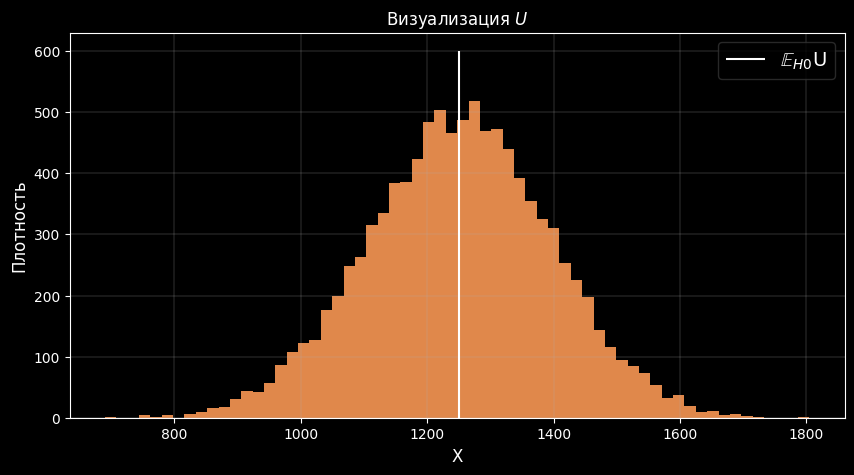

In [15]:
numpy.random.seed(35)
alpha=0.05
sample_size = 50
N_exps = 10000

statistics = []

for i in tqdm_notebook(range(N_exps)):
    # Генерирую выборку из одного распределения
    A = distr_a.rvs(sample_size)
    B = distr_a.rvs(sample_size)

    U = calculate_U(A, B)

    statistics.append(U)

EU = len(A) * len(B) / 2
pyplot.figure(figsize=(10, 5))
pyplot.title("Визуализация $U$", fontsize=12)
pyplot.vlines(EU, 0, 600, color='white', label='$\mathbb{E}_{H0}$U')
pyplot.hist(statistics, bins='auto')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=14)
pyplot.show()


Что теперь мы можем сделать? Взять квантили этого распределения как критические области и наш критерий готов.

In [16]:
numpy.quantile(statistics, [0.025, 0.975])

array([ 962.975, 1535.025])

Можем посчитать p-value:

In [18]:
stat_obs = calculate_U(sample_a, sample_b)
(statistics > stat_obs).mean() * 2 # умножаем на 2, так как критерий двусторонний

np.float64(0.0)

Мы уже знаем, что в задаче с двумя нормальными распределениями он точно отверг гипотезу $H_0$ об однородности выборок: там значение 2205 > 1532.05.

Минус текущего решения – оно будет подходить только для текущей задачи. Если мы поменяем распределения или размеры выборок – все изменится.
Но тут на помощь приходит теория: было доказано, что если выборки $A$ и $B$ из одного распределения, то

$$
\begin{align}
    &U \overset{d}\rightarrow \mathcal{N}(\mathbb{E}U, \mathbb{D}U), \text{где}\\
    &U^{(*)} = \sum_{i}^N\sum_{j}^M I[A_i < B_j],\\
    &\mathbb{E} U = \dfrac{NM}{2},\\
    &\mathbb{D}U = \dfrac{NM(N + M + 1)}{12}
\end{align}
$$

----

Мы рассмотрели выше примеры, когда в выборке нет пересекающихся значений. Для непрерывных распределений это нормально, но что делать в случае дискретных распределений? Как считать пару $I[A_i < B_j]$, особенно если в выборках будет только одно значение? В этом случае нужно скорректировать формулу $U = \sum_{i}^N\sum_{j}^M I[A_i < B_j] + \sum_{i}^N\sum_{j}^M \dfrac{1}{2}I[A_i = B_j]$. Тогда мат. ожидание $U$ даже в случае выборок из одинаковых значений будет равно $\dfrac{NM}{2}$, что нам и нужно. Кроме этого применяется поправка к формуле дисперсии. И критерий остается валидным.

При малых размерах выборок используются табличные значения.

In [20]:
def mann_whitney_distribution(A, B):
    """Функция, возвращающая распределение для статистики U."""
    N = len(A)
    M = len(B)
    DU = N * M * (N + M + 1) / 12
    return norm(loc=N * M / 2, scale=DU ** (1/2))

Покажем, что теория соотносится с практикой:

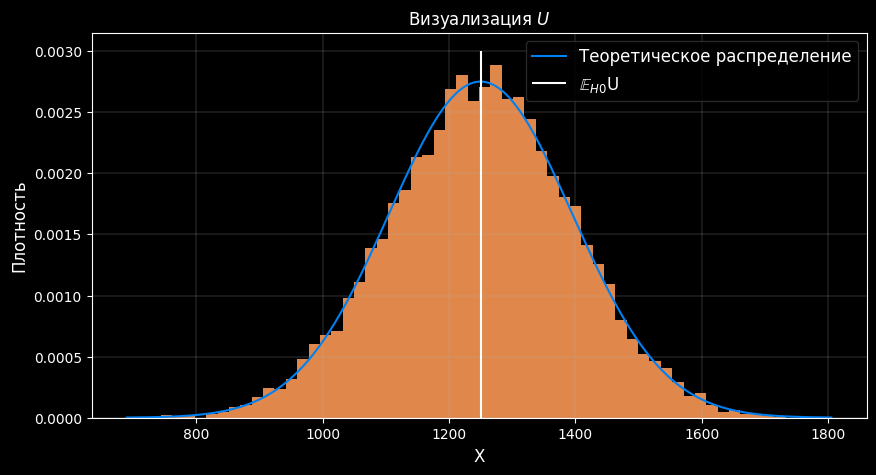

In [21]:
x = numpy.linspace(min(statistics), max(statistics), 1000)
distrib = mann_whitney_distribution(A, B)

EU = len(A) * len(B) / 2
pyplot.figure(figsize=(10, 5))
pyplot.title("Визуализация $U$", fontsize=12)
pyplot.hist(statistics, density=True, bins='auto')
pyplot.plot(x, distrib.pdf(x), label="Теоретическое распределение")
pyplot.vlines(EU, 0, 0.003, color='white', label='$\mathbb{E}_{H0}$U')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)
pyplot.show()

Видим достаточно точное совпадение, все отлично. Мы имеем статистику критерия, понимание, как она распределена при $H_0$, а значит, можем посчитать p-value. Критерий готов!

Кроме того, теоретические свойства этого критерия работают для любых непрерывных распределений, а не только для нормальных. Это не параметрический криетрий.

Минус текущего нашего решения – оно долго работает, а точнее за квадратичное время.  

**Идея как ускорить работу критерия:** давайте упорядочим все элементы на графике ниже. Самый левый элемент &mdash; первый, следующий &mdash; второй и т.д. Эти номера назовем рангами.
Будем опираться на ранги синей выборки.

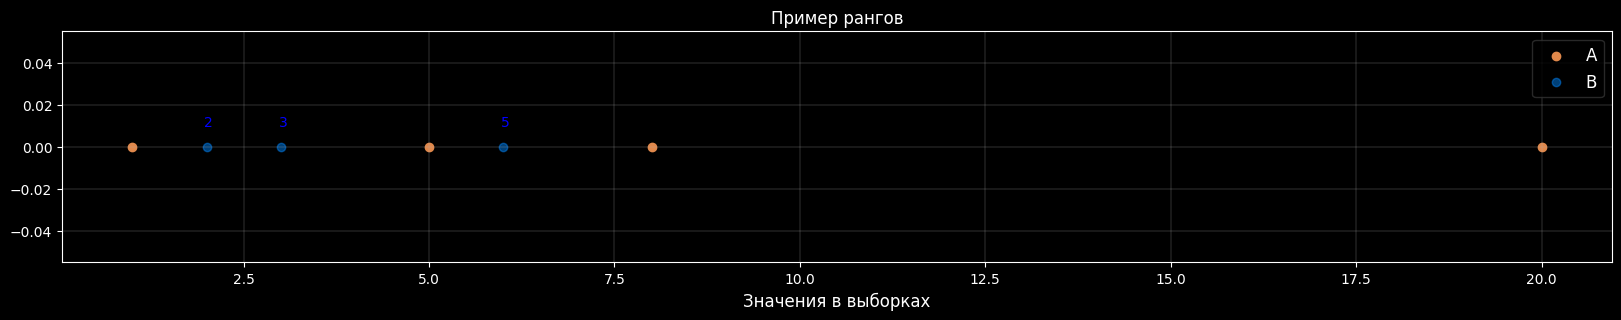

In [22]:
sample_a = [1, 5, 8, 20]
sample_b = [2, 3, 6]

ranks_b = stats.rankdata(sample_a + sample_b)[len(sample_b):]

pyplot.figure(figsize=(20, 3))
pyplot.title("Пример рангов", fontsize=12)
pyplot.scatter(sample_a, [0] * len(sample_a), label='A')

pyplot.scatter(sample_b, [0] * len(sample_b), alpha=0.5, label='B')
for elem, rank in zip(sorted(sample_b), sorted(ranks_b)):
    pyplot.text(elem - 0.03, 0.01, int(rank), c='blue')


pyplot.xlabel(f'Значения в выборках', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)
pyplot.show()

$R_j$ – ранг $B_j$ в выборке $(A_1,\ ...,\ A_N,\ B_1,\ ...,\ B_M)$.

$V = R_1 +\ ...\ + R_M$. Идея $V$: чем смещенней одна выборка относительно другой, тем больше/меньше сумма рангов у одной выборки.

В случае, если в выборке есть повторения, то ранг – число элементов меньше текущего плюс число элементов, равных текущему, деленное на 2. Но ранги начинаются с 1, поэтому к формуле прибавляется 1.

Например, в выборке [1, 1, 2, 3, 4, 4, 4] ранги будут равны [1.5, 1.5, 3, 4, 6, 6, 6].

**Утверждение:** $U = V - \dfrac{M (M + 1)}{2}$.


То есть мы можем переписать наш критерий, вычисляя статистику $U$ по формуле $V - \dfrac{M (M + 1)}{2}$. Зачем? Потому что это быстрее: чтобы посчитать все ранги, достаточно отсортировать выборку размера $N + M$ за время $(N + M)\log(N + M)$, что сильно быстрее квадратичного времени $NM$.

Поэтому **критерий Манна-Уитни часто называют критерием сумм рангов**.


Итоговый критерий реализован в питоне [scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html).

In [23]:
distr_a = norm(loc=1, scale=1)
distr_b = norm(loc=3, scale=1)

numpy.random.seed(8)
sample_a = distr_a.rvs(50)
sample_no_shift = distr_a.rvs(50)
sample_b = distr_b.rvs(50)

mannwhitneyu(sample_a, sample_b).pvalue


np.float64(4.699705065776074e-11)

Мы видим, что критерий нашел смещение, все отлично.

In [24]:
mannwhitneyu(sample_a, sample_no_shift).pvalue

np.float64(0.7174076711831379)

И не нашел смещения, когда его нет.

### Алгоритм критерия Манна-Уитни

Проверяемая гипотеза: $H_0: F=G,\ vs.\\ H_1: F \neq G$
- Вычисляются ранги выборки $A_1,\ ...\ A_N,\ B_1,\ ...\ B_M$.
- Сохраняются все ранги выборки $B$: это выборка $R$.
- Берется сумма рангов выборки $B$ в списке $A \& B$: $V = R_1 +\ ...\ + R_M$. Считается статистика $U = V - \dfrac{M (M + 1)}{2}$
- Считается мат. ожидание выборки, дисперсия выборки при корректности $H_0$:
$$
\begin{align}
    &\mathbb{E} U = \dfrac{NM}{2},\\
    &\mathbb{D} U = \dfrac{NM(N + M + 1)}{12}
\end{align}
$$


- $U \overset{d}\rightarrow \mathcal{N}(\mathbb{E}U, \mathbb{D}U)$. По этому распределению считаются квантили.
- При малых значениях выборок используют табличные значения.
- По умолчанию применяется для непрерывных распределений. Можно использовать и для дискретных с некоторыми поправками (вроде как они встроены в `scipy`).
- Если в выборках есть повторения, то в дисперсии используется поправка.
- Если в выборках могут быть совпададающие значения, то в расчет статистики вносится поправка, что они вносят половинчатный вклад (см. выше)

В чем главная прелесть данного критерия? Он **не зависит от шумов в данных**! Неважно, есть ли выбросы в вашей выборке, критерию это не важно: главное, сколько элементов меньше них.

-------


## При каких H1 Манн-Уитни будет мощным критерием?


Рассмотрим с вами 2 ситуации:

- Смещение 2 выборок
- Изменение дисперсии у выборок


Визуализируем эти 2 случая:

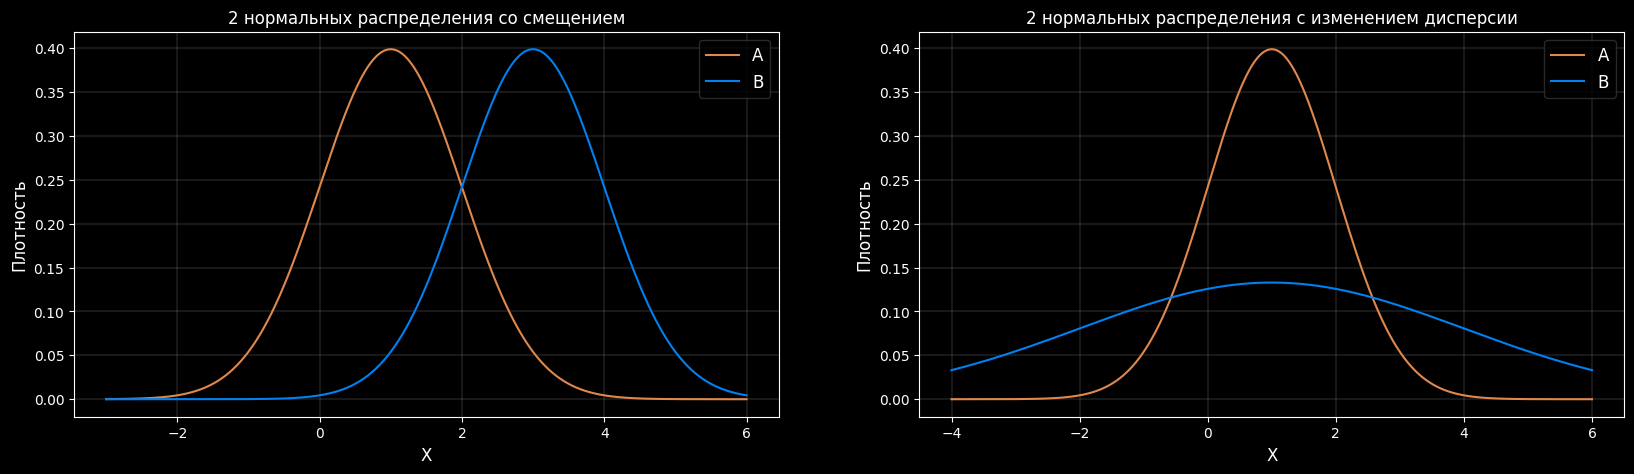

In [25]:
distr = norm(loc=1, scale=1)
distr_shift = norm(loc=3, scale=1)

distr_scaled = norm(loc=1, scale=3)


fig = pyplot.figure(figsize=(20, 5))

ax = fig.subplots(nrows=1, ncols=2)
x = numpy.linspace(-3, 6, 1000)
pyplot.subplot(1, 2, 1)
pyplot.title("2 нормальных распределения со смещением", fontsize=12)
pyplot.plot(x, distr.pdf(x), label='A')
pyplot.plot(x, distr_shift.pdf(x), label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)

pyplot.subplot(1, 2, 2)
x = numpy.linspace(-4, 6, 1000)
pyplot.title("2 нормальных распределения c изменением дисперсии", fontsize=12)
pyplot.plot(x, distr.pdf(x), label='A')
pyplot.plot(x, distr_scaled.pdf(x), label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)
pyplot.show()


Давайте оценим мощность критерия в каждом из этих 2 случаев. Как? С помощью механики Монте-Карло!


#### Случай 1: смещение выборок

In [ ]:
numpy.random.seed(8)
# Заводим счетчики количества отвергнутых гипотез для Манна-Уитни и для t-test
mann_bad_cnt = 0

# Прогоняем критерии 1000 раз
sz = 1000
for i in tqdm_notebook(range(sz)):
    # Генерируем распределение
    test = distr.rvs(1000)
    control = distr_shift.rvs(1000)

    # Считаем p-value
    mann_pvalue = mannwhitneyu(control, test, alternative='two-sided').pvalue

    # Отвергаем критерий на уровне 5%
    if mann_pvalue < 0.05:
        mann_bad_cnt += 1


# Строим доверительный интервал для уровня значимости критерия (или для FPR критерия)
left_mann, right_mann = proportion_confint(count = mann_bad_cnt, nobs = sz, alpha=0.05, method='wilson')
# Выводим результаты
print(f"Mann-whitneyu power: {round(mann_bad_cnt / sz, 4)}, ({round(left_mann, 4)}, {round(right_mann, 4)})")

  0%|          | 0/1000 [00:00<?, ?it/s]

Mann-whitneyu power: 1.0, (0.9962, 1.0)


Мы видим мощность 1. А в случае с увеличением дисперсии?

#### Случай 2: Разные дисперсии. Смещения нет

In [ ]:
numpy.random.seed(8)
# Заводим счетчики количества отвергнутых гипотез для Манна-Уитни и для t-test
mann_bad_cnt = 0

# Прогоняем критерии 1000 раз
sz = 1000
for i in tqdm_notebook(range(sz)):
    # Генерируем распределение
    test = distr.rvs(1000)
    control = distr_scaled.rvs(1000)

    # Считаем p-value
    mann_pvalue = mannwhitneyu(control, test, alternative='two-sided').pvalue

    # Отвергаем критерий на уровне 5%
    if mann_pvalue < 0.05:
        mann_bad_cnt += 1


# Строим доверительный интервал для уровня значимости критерия (или для FPR критерия)
left_mann, right_mann = proportion_confint(count = mann_bad_cnt, nobs = sz, alpha=0.05, method='wilson')
# Выводим результаты
print(f"Mann-whitneyu power: {round(mann_bad_cnt / sz, 4)}, ({round(left_mann, 4)}, {round(right_mann, 4)})")

  0%|          | 0/1000 [00:00<?, ?it/s]

Mann-whitneyu power: 0.071, (0.0567, 0.0886)


Мы видим очень маленькую мощность, близкую к 0.05!


**Вывод:** Манн-Уитни хорошо работает в случае смещения выборок, но не в случае разных дисперсий у теста и контроля. Что логично вытекает из того, как мы строили критерий.

### Односторонний критерий Манна-Уитни

Теперь давайте обсудим, как с помощью текущего критерия определять, в какую сторону произошло смещение?

Давайте посмотрим 2 ситуации: смещение синей выборки $B$ влево и вправо относительно рыжей выборки $A$. Где тогда будет значение статистики $U$?

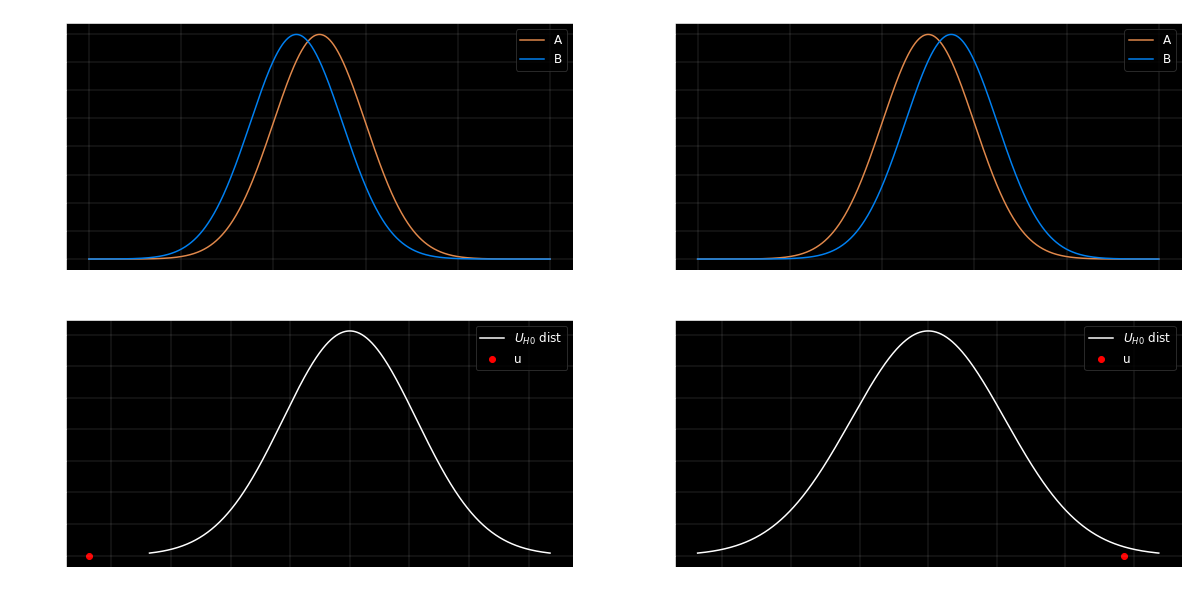

In [ ]:
numpy.random.seed(8)
x = numpy.linspace(-4, 6, 1000)

distr_a = norm(loc=1, scale=1)
distr_b_right = norm(loc=1.5, scale=1)
distr_b_left = norm(loc=0.5, scale=1)

sample_a = distr_a.rvs(100)
sample_b_right = distr_b_right.rvs(150)
sample_b_left = distr_b_left.rvs(150)

N = len(sample_a)
M = len(sample_b_right)
EU = N * M / 2
DU = numpy.sqrt(N * M * (N + M + 1) / 12)
mann_whitney_dist = norm(loc=EU, scale=DU)
mw_x = numpy.linspace(EU - 3 * DU, EU + 3 * DU, 1000)


fig = pyplot.figure(figsize=(20, 10))

ax = fig.subplots(nrows=2, ncols=2)

pyplot.subplot(2, 2, 1)
pyplot.title("Cмещение синей выборки влево", fontsize=12)
pyplot.plot(x, distr_a.pdf(x), label='A')
pyplot.plot(x, distr_b_left.pdf(x), label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)


pyplot.subplot(2, 2, 3)
u = calculate_U(sample_a, sample_b_left)
pyplot.title("Распределение Манна-Уитни при H0", fontsize=12)
pyplot.plot(mw_x, mann_whitney_dist.pdf(mw_x), c='white', label='$U_{H0}$ dist')
pyplot.scatter(u, 0, c='red', label='u')

pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)


pyplot.subplot(2, 2, 2)
pyplot.title("Cмещение синей выборки вправо", fontsize=12)
pyplot.plot(x, distr_a.pdf(x), label='A')
pyplot.plot(x, distr_b_right.pdf(x), label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)

pyplot.subplot(2, 2, 4)
u = calculate_U(sample_a, sample_b_right)
pyplot.title("Распределение Манна-Уитни при H0", fontsize=12)
pyplot.plot(mw_x, mann_whitney_dist.pdf(mw_x), c='white', label='$U_{H0}$ dist')
pyplot.scatter(u, 0, c='red', label='u')

pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)


pyplot.show()

В первом случае значение статистики U будет маленьким, а во втором – большим, что логично: в одном случае все ранги синей выборки маленькие, а в другом – большие. Поэтому и статистика $U$ будет либо в левом хвосте (если синее распределение левее), либо в правом хвосте (наоборот).

В критерии Манна-Уитни это также реализовано через альтернативу:

In [ ]:
mannwhitneyu(sample_b_right, sample_a, alternative='greater').pvalue

0.005465026978270606

In [ ]:
mannwhitneyu(sample_b_left, sample_a, alternative='less').pvalue

4.6704977909583455e-05

Таким образом вы можете проверять, распределение левее или правее вашего изначального рыжего распределения.

Теперь давайте рассмотрим еще 1 пример.

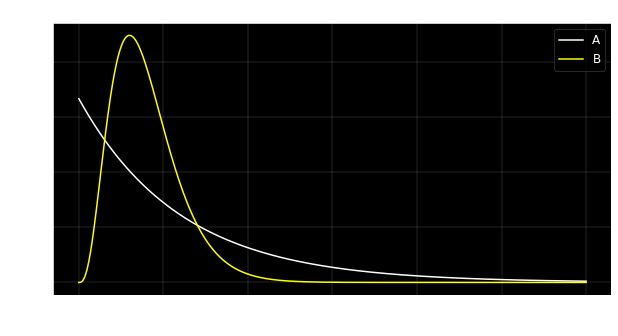

In [ ]:
distr_a = expon(loc=0, scale=6)
distr_b = gamma(a=4, scale=1)
x = numpy.linspace(0, 30, 1000)

fig = pyplot.figure(figsize=(10, 5))
pyplot.title("Что левее? Плотность распределения", fontsize=12)

pyplot.plot(x, distr_a.pdf(x), c='white', label='A')
pyplot.plot(x, distr_b.pdf(x), c='yellow', label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)
pyplot.show()

In [ ]:
distr_a.expect()

6.0

In [ ]:
distr_b.expect()

4.000000000000001

Какое в этом случае распределение будет левее по мнению Манна-Уитни?

In [ ]:
numpy.random.seed(8)
# Заводим счетчики количества отвергнутых гипотез для Манна-Уитни и для t-test
mann_bad_cnt_left = 0
mann_bad_cnt_right = 0


# Прогоняем критерии 1000 раз
sz = 1000
for i in tqdm_notebook(range(sz)):
    # Генерируем распределение
    A = distr_a.rvs(1000)
    B = distr_b.rvs(1000)

    # Считаем p-value
    mann_pvalue_left = mannwhitneyu(A, B, alternative='less').pvalue  # H1: A < B
    mann_pvalue_right = mannwhitneyu(A, B, alternative='greater').pvalue  # H1: A > B


    # отвергаем критерий на уровне 5%
    if mann_pvalue_left < 0.05:
        mann_bad_cnt_left += 1

    if mann_pvalue_right < 0.05:
        mann_bad_cnt_right += 1


print(f"Power for alternative 'Less': (A < B): {round(mann_bad_cnt_left / sz * 100, 1)}%")
print(f"Power for alternative 'Greater': power (A > B): {round(mann_bad_cnt_right / sz * 100, 1)}%")


  0%|          | 0/1000 [00:00<?, ?it/s]

Power for alternative 'Less': (A < B): 0.0%
Power for alternative 'Greater': power (A > B): 91.1%


Критерий Манна-Уитни посчитал, что белое распределение правее желтого. Правда ли это? Здесь зависит от того, как мы **формально** определяем, что значит левее или правее.

В данном случае поступим просто: определим "правее" – это значит, что Манн-Уитни чаще будет отвергать нулевую гипотезу в пользу альтернативы "greater". Нам надо понять, есть ли у этого правила какое-то применение на практике?

Посмотрим на другой пример:

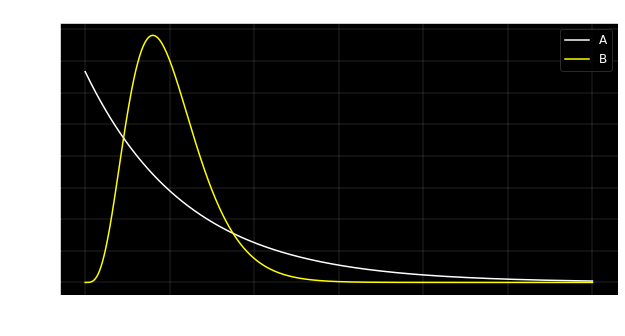

  0%|          | 0/1000 [00:00<?, ?it/s]

Less power A < B: 86.2%
Greater power A > B: 0.0%


In [ ]:
distr_a = expon(loc=0, scale=6)
distr_b = gamma(a=5, scale=1)
x = numpy.linspace(0, 30, 1000)

fig = pyplot.figure(figsize=(10, 5))

pyplot.title("Что левее? Плотность распределения", fontsize=12)

pyplot.plot(x, distr_a.pdf(x), c='white', label='A')
pyplot.plot(x, distr_b.pdf(x), c='yellow', label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)
pyplot.show()


numpy.random.seed(8)
# Заводим счетчики количества отвергнутых гипотез для Манна-Уитни и для t-test
mann_bad_cnt_left = 0
mann_bad_cnt_right = 0


# Прогоняем критерии 1000 раз
sz = 1000
for i in tqdm_notebook(range(sz)):
    # Генерируем распределение
    A = distr_a.rvs(1000)
    B = distr_b.rvs(1000)

    # Считаем p-value
    mann_pvalue_left = mannwhitneyu(A, B, alternative='less').pvalue
    mann_pvalue_right = mannwhitneyu(A, B, alternative='greater').pvalue


    # Отвергаем критерий на уровне 5%
    if mann_pvalue_left < 0.05:
        mann_bad_cnt_left += 1

    if mann_pvalue_right < 0.05:
        mann_bad_cnt_right += 1


print(f"Less power A < B: {round(mann_bad_cnt_left / sz * 100, 1)}%")
print(f"Greater power A > B: {round(mann_bad_cnt_right / sz * 100, 1)}%")


In [ ]:
distr_a.expect()

6.0

In [ ]:
distr_b.expect()

5.0

Теперь белое распределение левее желтого по правилам Манна-Уитни. Сравним 2 картины между собой.

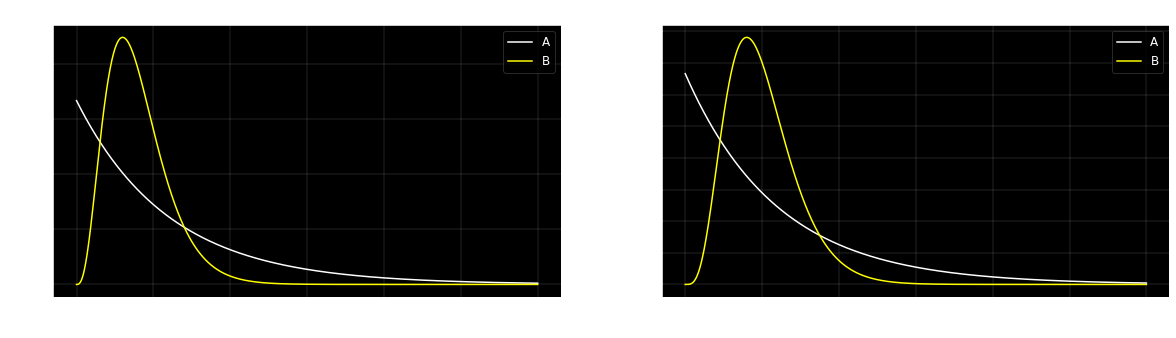

In [ ]:
distr_a = expon(loc=0, scale=6)
distr_b_2 = gamma(a=5, scale=1)
distr_b_1 = gamma(a=4, scale=1)

x = numpy.linspace(0, 30, 1000)

fig = pyplot.figure(figsize=(20, 5))

ax = fig.subplots(nrows=1, ncols=2)

pyplot.subplot(1, 2, 1)
pyplot.title("Белое распределение правее желтого", fontsize=15)
pyplot.plot(x, distr_a.pdf(x), c='white', label='A')
pyplot.plot(x, distr_b_1.pdf(x), c='yellow', label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)


pyplot.subplot(1, 2, 2)
pyplot.title("Белое распределение левее желтого", fontsize=15)
pyplot.plot(x, distr_a.pdf(x), c='white', label='A')
pyplot.plot(x, distr_b_2.pdf(x), c='yellow', label='B')
pyplot.xlabel(f'X', fontsize=12)
pyplot.ylabel('Плотность', fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.legend(fontsize=12)
pyplot.show()


В первом случае Манн-Уитни считает, что белое распределение правее желтого, а во втором – наоборот.

Вернемся к вопросу: Есть ли у этого правила "правее" Манна-Уитни какое-то реальное применение?

1) На текущем примере односторонняя гипотеза не применима: 2 картинки практически идентичны, а результаты критерия абсолютно разные. Сложно придумать простую интерпретацию, которая объясняла бы это различие в результатах. Особенно в реальных бизнес-задачах.
2) Но если бы вы получили 2 нормальных распределения со смещением, как мы смотрели выше, то односторонний критерий Манна-Уитни бы работал валидно и имел понятную интерпретацию: 2 распределения имеют одинаковую форму, но имеют смещенные мат. ожидания.

Главное отличие в этих примерах в том, что в одном случае была понятная интерпретация результатов, а в другом – нет.

Поэтому, главное что нужно вынести из этого раздела: очень осторожно относитесь к односторонним гипотезам Манна-Уитни. Подумайте, есть ли у правила определения "лево-право" критерия Манна-Уитни понятная бизнес-интерпретация в вашем примере.

## Работает ли Манн-Уитни для других нулевых гипотез?

Что мы знаем про Манна-Уитни? Это критерий, который вообще не смотрит на значения элементов, а значит устойчив к шумам. Поэтому было бы интересно применить его к решению других задач, где шумы могут помешать получить стат. значимые результаты. Мы рассмотрим с вами 3 гипотезы и посмотрим, можно ли использовать там Манна-Уитни? Если да, то это даст возможность нивелировать влияние выбросов в этих гипотезах и сделать больше прокрасов.

1. Сравнение средних: $H_0: \mathbb{E}A = \mathbb{E}B$.
2. Сравнение медиан: $H_0: \text{median}\ A = \text{median}\ B$.
3. Смещения выборок между собой: $H_0: \mathbb{P}(A < B) = \dfrac{1}{2}$. То есть вероятность, что в одной выборке значения будут лежать левее или правее второго распределения равна 0.5.


Для проверки рассмотрим 2 симметричных распределения для которых все три гипотзы выполняются:
- U[−1, 1] — равномерное распределение от −1 до 1
- U[−100, 100] — равномерное распределение от −100 до 100

Про эти два распределения мы знаем, что у них равны средние и медианы, и что они симметричны относительно 0. Кроме того, вероятность, что сгенерированное значение в первой выборке будет больше значения во второй выборке, равна $\dfrac{1}{2}$. Или, если сформулировать математически, $\mathbb{P}(T > C) = \dfrac{1}{2}$, где T и C — выборки теста и контроля.

Работает ли здесь корректно Манн-Уитни? Для этого мы запустим эксперимент 1000 раз и посмотрим на количество отвержений нулевой гипотезы у критерия.


In [ ]:
numpy.random.seed(8)
# Заводим счетчики количества отвергнутых гипотез для Манна-Уитни и для t-test
mann_bad_cnt = 0
ttest_bad_cnt = 0

# Прогоняем критерии 1000 раз
sz = 1000
for i in tqdm_notebook(range(sz)):
    # Генерируем распределение
    test = uniform(loc=-1, scale=2).rvs(1000) # U[-1, 1]
    control = uniform(loc=-100, scale=200).rvs(1000) # U[-100, 100]

    # Считаем p-value
    mann_pvalue = mannwhitneyu(control, test, alternative='two-sided').pvalue
    ttest_pvalue = ttest_ind(control, test, alternative='two-sided').pvalue

    # Отвергаем критерий на уровне 5%
    if mann_pvalue < 0.05:
        mann_bad_cnt += 1

    if ttest_pvalue < 0.05:
        ttest_bad_cnt += 1

# Строим доверительный интервал для уровня значимости критерия (или для FPR критерия)
left_mann_level, right_mann_level = proportion_confint(count = mann_bad_cnt, nobs = sz, alpha=0.05, method='wilson')
left_ttest_level, right_ttest_level = proportion_confint(count = ttest_bad_cnt, nobs = sz, alpha=0.05, method='wilson')
# Выводим результаты
print(f"Mann-whitneyu significance level: {round(mann_bad_cnt / sz, 4)}, ({round(left_mann_level, 4)}, {round(right_mann_level, 4)})")
print(f"T-test significance level: {round(ttest_bad_cnt / sz, 4)}, ({round(left_ttest_level, 4)}, {round(right_ttest_level, 4)})")

  0%|          | 0/1000 [00:00<?, ?it/s]

Mann-whitneyu significance level: 0.099, (0.082, 0.1191)
T-test significance level: 0.056, (0.0434, 0.072)


Мы видим, что Манн-Уитни ошибся в 2 раза больше, чем должен был! При этом пример валиден: t-test работает нормально.

А значит Манн-Уитни НЕ проверяет сравнение средних, смещения медиан и смещения выборок $\mathbb{P}(A < B) = \dfrac{1}{2}$!

Мы посмотрели 1 пример. В нем ошибка 1 рода была всего 10% вместо 5%: иногда это может быть не страшно. Но правда ли, что это наихудший возможный случай? Особенно интересно ответить на этот вопрос на более практических примерах: например в AB-тестах. Ведь это наиболее популярная задача на практике у аналитиков.

-----

Давайте разберем новый кейс на примере выдачи скидки. Мы выдали скидки. Количество платящих пользователей увеличилось, но ARPPU (Average revenue per paying user) упал. Наша ключевая метрика здесь — выручка. Мы хотим понять: начнём ли мы больше зарабатывать со скидками. Или выросло ли ARPU (Average revenue per user) или математическое ожидание выручки?

Сразу зафиксируем проверяемую гипотезу о равенстве средних: $H_0$ — средний чек не изменился vs. $H_1$ — средний чек вырос среди всех пользователей.

Искусственно просимулируем эксперимент, который мог бы произойти в реальности. Пусть распределение ненулевой части метрики подчиняется экспоненциальному распределению (это люди, которые платят на сайте). Для выручки это хорошее приближение.



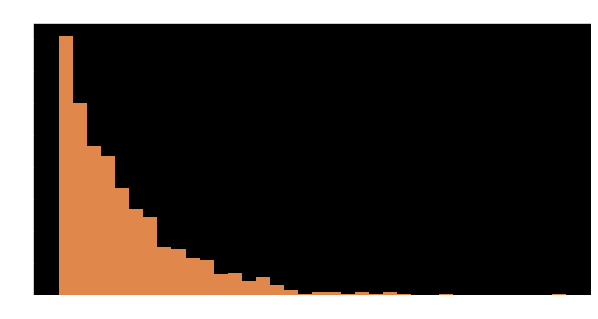

In [ ]:
pyplot.figure(figsize=(10, 5))
pyplot.title("Визуализация возможных ARPPU", fontsize=12)
pyplot.hist(expon(loc=0, scale=6).rvs(1000), bins='auto')
pyplot.show()

1. Пусть нашими скидками мы увеличили число платящих пользователей на 5%.
    - Изначально в контроле было 50% нулей. Половина пользователей ничего не покупали на сайте.
    - В тесте стало 55% платящих пользователей.

2. Раньше пользователь в среднем платил 7 рублей, а сейчас из-за скидки он платит 6 ₽, скидка была примерно 15%. Тогда математическое ожидание выручки в контроле было 3.5 ₽ (7 * 0.5), а в тесте — 3.3 ₽ (6 * 0.55).

То есть платящих пользователей стало больше, а средний чек упал. Давайте снова запустим Монте-Карло 1000 раз и проверим, что здесь покажут T-test с Манном-Уитни, используя односторонние критерии.

Демонстрация результатов:

In [ ]:
numpy.random.seed(8)
# Заводим счетчики количества отвергнутых гипотез для Манна-Уитни и для t-test
mann_bad_cnt = 0
ttest_bad_cnt = 0
sz = 10000

for i in tqdm_notebook(range(sz)):
    test_zero_array = bernoulli(p=0.55).rvs(5000)
    control_zero_array = bernoulli(p=0.5).rvs(5000)
    test = expon(loc=0, scale=6).rvs(5000) * test_zero_array # ET = 3.3
    control = expon(loc=0, scale=7).rvs(5000) * control_zero_array # EC = 3.5

    # Проверяем гипотезу
    mann_pvalue = mannwhitneyu(test, control, alternative='greater').pvalue
    ttest_pvalue = ttest_ind(test, control, alternative='greater').pvalue
    if mann_pvalue < 0.05:
        mann_bad_cnt += 1

    if ttest_pvalue < 0.05:
        ttest_bad_cnt += 1

# Строим доверительный интервал
left_mann_fpr, right_mann_fpr = proportion_confint(count = mann_bad_cnt, nobs = sz, alpha=0.05, method='wilson')
left_ttest_fpr, right_ttest_fpr = proportion_confint(count = ttest_bad_cnt, nobs = sz, alpha=0.05, method='wilson')
# Выводим результаты
print(f"Mann-whitneyu GREATER FPR: {round(mann_bad_cnt / sz, 4)}, ({round(left_mann_fpr, 4)}, {round(right_mann_fpr, 4)})")
print(f"T-test GREATER FPR: {round(ttest_bad_cnt / sz, 4)}, ({round(left_ttest_fpr, 4)}, {round(right_ttest_fpr, 4)})")

  0%|          | 0/10000 [00:00<?, ?it/s]

Mann-whitneyu GREATER FPR: 0.8427, (0.8354, 0.8497)
T-test GREATER FPR: 0.0002, (0.0001, 0.0007)


Мы знаем, что мат. ожидание в тесте МЕНЬШЕ, чем в контроле: скидки в текущем примере ВРЕДНЫ. Но Манн-Уитни показал бы в 84% случаев, что скидки полезны! И мы бы раскатили изменение! А должен был обманывать лишь в 5% случаев. В этот раз ошибка была не 10% как в случае выше, а 84%!

При этом T-test нас обманул < 1% случаев, что соответствует нашему FPR.

## Итог

На текущей лекции мы вывели с вами критерий однородности Манна-Уитни. Какие выводы мы извлекли из текущей лекции:

- **Не пытайтесь применить критерий, который проверяет одну нулевую гипотезу, для решения других задач, для которых он не предназначен!** Этот совет вам может помочь не только в текущием примере с Манном-Уитни, но и в других задачах.
- Манн-Уитни проверяет только гипотезу $H_0: F = G$. Лучше всего он работает в ситуации, когда вы проверяете смещения выборок. Если у вас измениллась дисперсия у одной из выборок, то он это плохо детектирует.
    - Очень аккуратно проверяйте применимость односторонней гипотезы Манна-Уитни: она подходит далеко не для всех задач и в очень редких кейсах имеет понятную интерпретацию для бизнеса.
- Манн-Уитни не применим для гипотезы равенства средних! Почему мы отдельно акцентируем внимание на эту тему? Это заблуждение настолько часто приводит к неправильным выводам в реальном бизнесе, что мы в Авито написали специальную [статью, чтобы предостеречь других аналитиков](https://habr.com/ru/companies/avito/articles/709596/).

Исходя из этих аргументов в Авито мы не используем этот критерий на практике.